* This notebook contains data cleaning, preprocessing text, train model with bert huggingface 

# Install Library

In [1]:
%%time

!pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 10.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=5deb8661f855f35d8bb1f25c0c5c9966a9121ef507251dc7bc7dd5335dfed1db
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect
CPU times: user 208 ms, sys: 45 ms, total: 253 ms
Wall time: 15.1 s


In [2]:
%%time

!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.2 MB/s eta 0:00:00eta 0:00:01
CPU times: user 167 ms, sys: 30.3 ms, total: 197 ms
Wall time: 12.2 s


In [3]:
%%time

!pip install num2words

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 3.5 MB/s eta 0:00:00a 0:00:01
CPU times: user 144 ms, sys: 33.2 ms, total: 178 ms
Wall time: 11.8 s


In [4]:
%%time

!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 45.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tsfresh 0.20.3 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
CPU times: user 266 ms, sys: 59.3 ms, total: 325

# Load Files

In [5]:
%%time

import warnings
warnings.filterwarnings('ignore')

CPU times: user 42 µs, sys: 11 µs, total: 53 µs
Wall time: 55.6 µs


In [6]:
%%time

import numpy as np
import pandas as pd
import matplotlib
import scipy
import re
import os
from datasets import load_dataset, Dataset

from num2words import num2words
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

# ML imports:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.cluster import KMeans

# DL imports:
from transformers import AutoTokenizer, TrainingArguments, Trainer
from torch.utils.data import DataLoader
import evaluate

CPU times: user 21.7 s, sys: 2.03 s, total: 23.7 s
Wall time: 32.8 s


In [7]:
%%time

# Download necessary resources from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corp

In [8]:
%%time

# Initialize the stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

CPU times: user 49 µs, sys: 6 µs, total: 55 µs
Wall time: 58.9 µs


In [9]:
%%time

score = pd.read_csv('/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv')
validation = pd.read_csv('/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv')
sample_submission = pd.read_csv('/kaggle/input/jigsaw-toxic-severity-rating/sample_submission.csv')

CPU times: user 265 ms, sys: 36.6 ms, total: 301 ms
Wall time: 824 ms


In [10]:
%%time

# Decode or remove

# Function to clean text data and handle encoding issues
def clean_text(text):
    # Remove encoding issues by normalizing and decoding potential artifacts
    cleaned_text = text.encode('ascii', 'ignore').decode('utf-8', 'ignore')  # Remove non-ASCII characters
    cleaned_text = cleaned_text.replace('\n', ' ').replace('\r', ' ')  # Replace newlines with spaces
    cleaned_text = cleaned_text.strip()  # Remove leading and trailing whitespace
    return cleaned_text

# Apply the cleaning function to the text column
score['text'] = score['text'].apply(clean_text)

CPU times: user 13.8 ms, sys: 2.09 ms, total: 15.8 ms
Wall time: 19.4 ms


In [11]:
%%time

# Apply lowercasing to the cleaned text column
score['text'] = score['text'].str.lower()

CPU times: user 3.17 ms, sys: 1.92 ms, total: 5.09 ms
Wall time: 4.83 ms


In [12]:
%%time

# Function to remove punctuation and special characters
def remove_punctuation_special_chars(text):
    # Remove all non-alphanumeric characters except spaces
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Apply the function to remove punctuation and special characters
score['text'] = score['text'].apply(remove_punctuation_special_chars)

CPU times: user 132 ms, sys: 1.01 ms, total: 133 ms
Wall time: 132 ms


In [13]:
%%time

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Apply the function to remove stopwords from the cleaned text
score['text'] = score['text'].apply(remove_stopwords)

CPU times: user 110 ms, sys: 3.01 ms, total: 113 ms
Wall time: 113 ms


In [14]:
%%time

# Function to apply stemming
def apply_stemming(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Function to apply lemmatization
def apply_lemmatization(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Apply stemming
score['text'] = score['text'].apply(apply_stemming)

# Apply lemmatization
score['text'] = score['text'].apply(apply_lemmatization)

CPU times: user 13.2 s, sys: 118 ms, total: 13.3 s
Wall time: 13.3 s


# Create New Labeled Data Using Clusters Method

In [15]:
%%time

# Use clusters to define label
text_data = score['text']

CPU times: user 110 µs, sys: 8 µs, total: 118 µs
Wall time: 122 µs


In [16]:
%%time

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Transform the text into TF-IDF features
X_tfidf = vectorizer.fit_transform(text_data)

CPU times: user 352 ms, sys: 12.9 ms, total: 365 ms
Wall time: 372 ms


In [17]:
%%time

# Cluster the text using K-means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_tfidf)

CPU times: user 6.54 s, sys: 114 ms, total: 6.65 s
Wall time: 2.08 s


KMeans(n_clusters=3, random_state=42)

In [18]:
%%time

#  Define labels for each cluster
cluster_labels = {0: "positive", 1: "negative", 2: "neutral"}

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


In [19]:
%%time

# Initialize the list to store predicted labels
predicted_labels = []

# Process each sentence in the 'text' column of the score DataFrame
for sentence in score['text']:
    # Transform the preprocessed sentence into TF-IDF features
    features = vectorizer.transform([sentence])
    
    # Predict the cluster of the sentence
    cluster = kmeans.predict(features)
    
    # Get the label for the predicted cluster
    label = cluster_labels[cluster[0]]
    
    # Store the predicted label in the list
    predicted_labels.append(label)

CPU times: user 8.18 s, sys: 25.5 ms, total: 8.21 s
Wall time: 8.21 s


In [20]:
%%time

# Add the predicted labels as a new column to the original dataset 
score['predicted_label'] = predicted_labels

CPU times: user 1.47 ms, sys: 26 µs, total: 1.5 ms
Wall time: 1.4 ms


In [21]:
%%time

# Save the updated DataFrame to a CSV file
output_file_path = 'new_score.csv'  
score.to_csv(output_file_path, index=False)

CPU times: user 85.4 ms, sys: 2.02 ms, total: 87.5 ms
Wall time: 88.1 ms


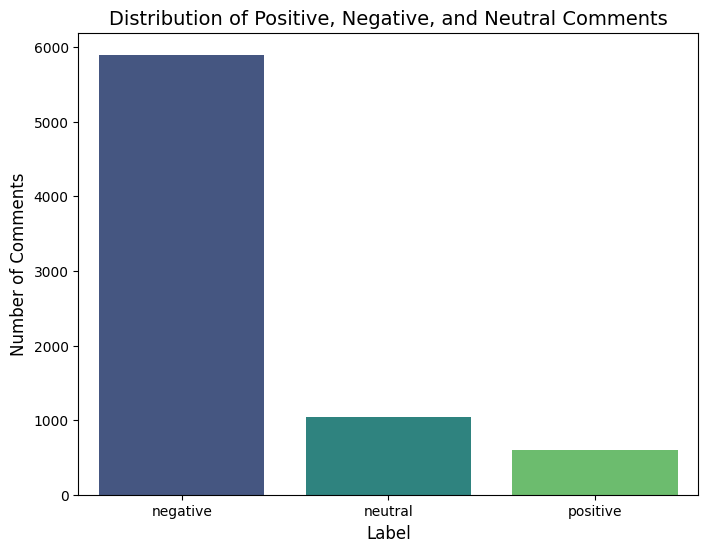

CPU times: user 504 ms, sys: 188 ms, total: 692 ms
Wall time: 493 ms


In [22]:
%%time

# Visualize the distribution of positive, negative, and neutral comments
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of occurrences of each label
label_counts = score['predicted_label'].value_counts()

# Set up the visualization
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')

# Add labels and title
plt.title('Distribution of Positive, Negative, and Neutral Comments', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Number of Comments', fontsize=12)
plt.show()

* Positive Cluster : These comments might be praising something, expressing agreement, or generally using positive language

* Negative Cluster : These are likely to include complaints, criticisms, or disagreement

* Neutral Cluster : These comments are often factual, balanced, or may express mixed feelings